Decision Trees

Like SVMs, Decision Trees are versatile Machine Learning algorithms that can perform both classification and regression tasks, and even multioutput tasks. They are powerful algorithms, capable of fitting complex datasets.

In this module we will start by discussing how to train, visualize, and make predictions with Decision Trees. Then we will go through the CART training algorithm used by Scikit-Learn, and we will discuss how to regularize trees and use them for regression tasks. Finally, we will discuss some of the limitations of Decision Trees.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Training and Visualizing a Decision Tree

To understand Decision Trees, let’s build one and take a look at how it makes predictions.

In [14]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth = 2, random_state=42)    #
tree_clf.fit(X, y)    #

DecisionTreeClassifier(max_depth=2, random_state=42)

Saving figure iris_tree


[Text(0.4, 0.8333333333333334, 'X[0] <= 2.45\ngini = 0.667\nsamples = 150\nvalue = [50, 50, 50]'),
 Text(0.2, 0.5, 'gini = 0.0\nsamples = 50\nvalue = [50, 0, 0]'),
 Text(0.6, 0.5, 'X[1] <= 1.75\ngini = 0.5\nsamples = 100\nvalue = [0, 50, 50]'),
 Text(0.4, 0.16666666666666666, 'gini = 0.168\nsamples = 54\nvalue = [0, 49, 5]'),
 Text(0.8, 0.16666666666666666, 'gini = 0.043\nsamples = 46\nvalue = [0, 1, 45]')]

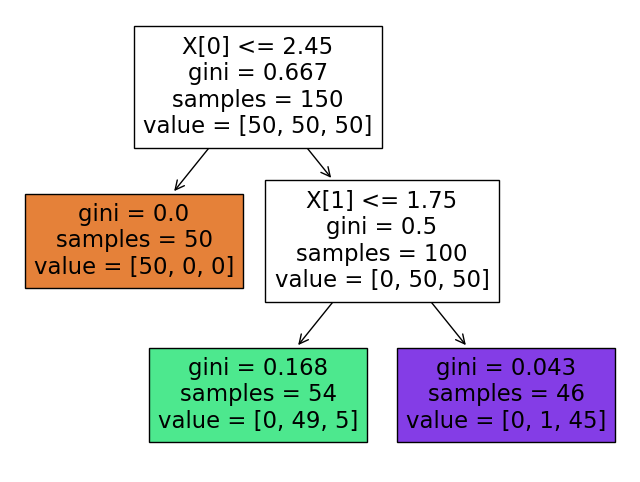

In [12]:
from sklearn import tree    #

plt.figure(figsize=(8,6))   #
save_fig("iris_tree")       #
tree.plot_tree(tree_clf, filled=True)    #

# Making Predictions

One of the many qualities of Decision Trees is that they require very little data preparation. _In fact, they don’t require feature scaling or centering at all._

A node’s gini attribute measures its impurity: a node is “pure” (gini=0) if all training instances it applies to belong to the same class.  The ___Gini Impurity___ is calculated as:

$$ G_{i} = 1 - \sum_{k=1}^{n} {p_{i,k}}^{2} $$

where $ p_{i,k} $ is the ratio of class $k$ instances among the training instances in the $i^{th}$ node.

The following figure shows the above Decision Tree’s decision boundaries:

Saving figure decision_tree_decision_boundaries_plot


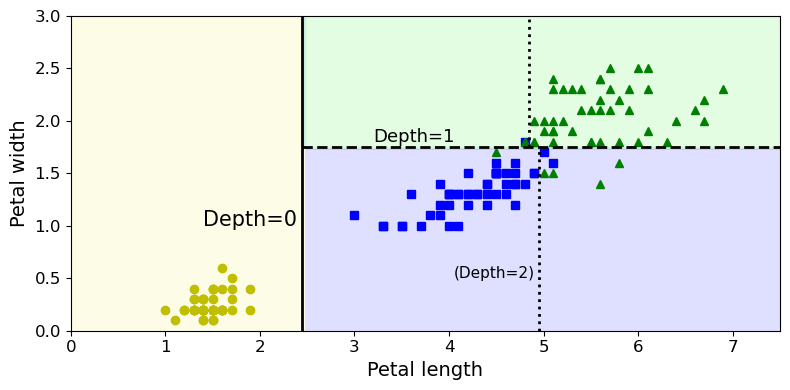

In [6]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)

save_fig("decision_tree_decision_boundaries_plot")
plt.show()

# Predicting Classes and Class Probabilities

A Decision Tree can also estimate the probability that an instance belongs to a particular class $k$. 

In [7]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [8]:
tree_clf.predict([[5, 1.5]]) # outcome predicts class [1] which we see above is 90%

array([1])

# The CART Training Algorithm

Scikit-Learn uses the Classification and Regression Tree (CART) algorithm to train Decision Trees (also called “growing” trees). The algorithm works by first splitting the training set into two subsets using a single feature $k$ and a threshold $t_k$.

How does it choose $k$ and $t_k$? It searches for the pair $(k, t_k)$ that produces the purest subsets (weighted by their size). The following equation gives the cost function that the algorithm tries to minimize.

<img src="figures/CART_cost_function.png " width ="500" />

The following hyperparameters control the stopping conditions for tree growth:

- `max_depth`
- `min_samples_leaf`
- `min_samples_split`
- `min_weight_fraction_leaf`
- `min_leaf_nodes`

# Computational Complexity

Making predictions requires traversing the Decision Tree from the root to a leaf, and generally requires an overall prediction complexity of $ O(log(m)) $, where $m$ is the number of features. So predictions are very fast, even when deal‐ ing with large training sets.

The training algorithm compares all features (or less if max_features is set) on all samples at each node, and generally has a training complexity of $O(n \times m log(m)) $.

# Gini Impurity or Entropy

By default, the Gini impurity measure is used, but you can select the entropy impurity measure instead by setting `criterion=entropy`.

Entropy of the $i^{th}$ node can be calculated by:

<img src="figures/entropy.png " width ="200" height=200 />

# Regularization Hyperparameters

Decision Trees make very few assumptions about the training data. If left unconstrained, the tree structure will adapt itself to the training data, fitting it very closely—indeed, most likely overfitting it.

To avoid overfitting the training data, you need to restrict the Decision Tree’s freedom during training. As you know by now, this is called ___regularization___.  There are numerous regularization hyperparameters, such as the max_depth hyperparameter (the default value is None, which means unlimited). Reducing max_depth will regularize the model and thus reduce the risk of overfitting.

Other algorithms work by first training the Decision Tree without restrictions, then pruning (deleting) unnecessary nodes. A node whose children are all leaf nodes is considered unnecessary if the purity improvement it provides is not statistically significant.

The following figure shows two Decision Trees trained on the moons dataset. On the left the Decision Tree is trained with the default hyperparameters (i.e., no restrictions), and on the right it’s trained with min_samples_leaf=4.

Saving figure min_samples_leaf_plot


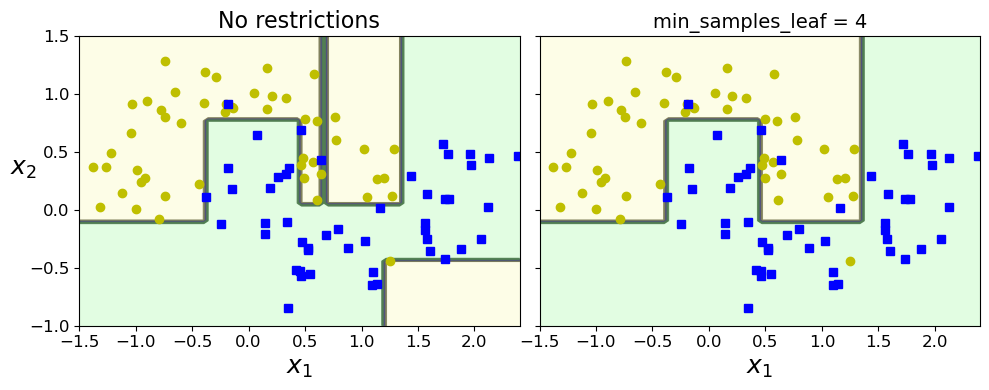

In [15]:
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)      #
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)     #
deep_tree_clf1.fit(Xm, ym)    #
deep_tree_clf2.fit(Xm, ym)    #

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.sca(axes[1])
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)
plt.ylabel("")

save_fig("min_samples_leaf_plot")
plt.show()

# Regression Trees

Decision Trees are also capable of performing regression tasks.

Let's start by generating some data:

In [21]:
# Quadratic training set + noise
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2    # quadratic data
y = y + np.random.randn(m, 1) / 10    # noise

Let's fit a decision tree to this data:

In [22]:
from sklearn.tree import DecisionTreeRegressor #

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42) #
tree_reg.fit(X, y) #

DecisionTreeRegressor(max_depth=2, random_state=42)

Let' visualize this decision tree:

Saving figure tree_regression_tree


[Text(0.5, 0.8333333333333334, 'X[0] <= 0.197\nsquared_error = 0.098\nsamples = 200\nvalue = 0.354'),
 Text(0.25, 0.5, 'X[0] <= 0.092\nsquared_error = 0.038\nsamples = 44\nvalue = 0.689'),
 Text(0.125, 0.16666666666666666, 'squared_error = 0.018\nsamples = 20\nvalue = 0.854'),
 Text(0.375, 0.16666666666666666, 'squared_error = 0.013\nsamples = 24\nvalue = 0.552'),
 Text(0.75, 0.5, 'X[0] <= 0.772\nsquared_error = 0.074\nsamples = 156\nvalue = 0.259'),
 Text(0.625, 0.16666666666666666, 'squared_error = 0.015\nsamples = 110\nvalue = 0.111'),
 Text(0.875, 0.16666666666666666, 'squared_error = 0.036\nsamples = 46\nvalue = 0.615')]

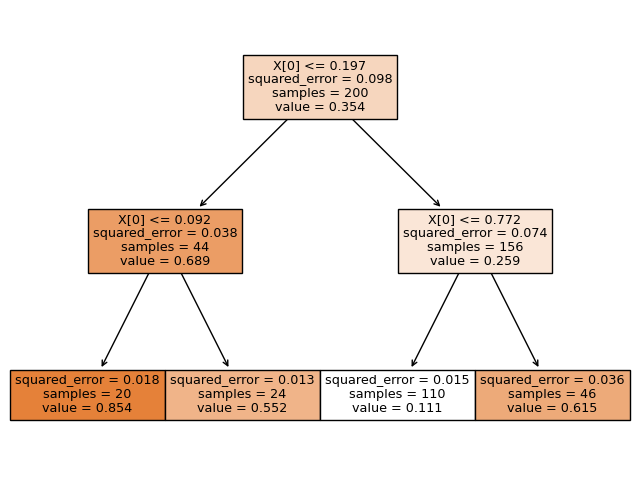

In [23]:
from sklearn import tree

plt.figure(figsize=(8,6))
save_fig("tree_regression_tree")
tree.plot_tree(tree_reg, filled=True)

Now let's look at a similiar decision tree, but allow the `max_depth` to grow to 3.  Also, let's view te decision boundaries:

Saving figure tree_regression_plot


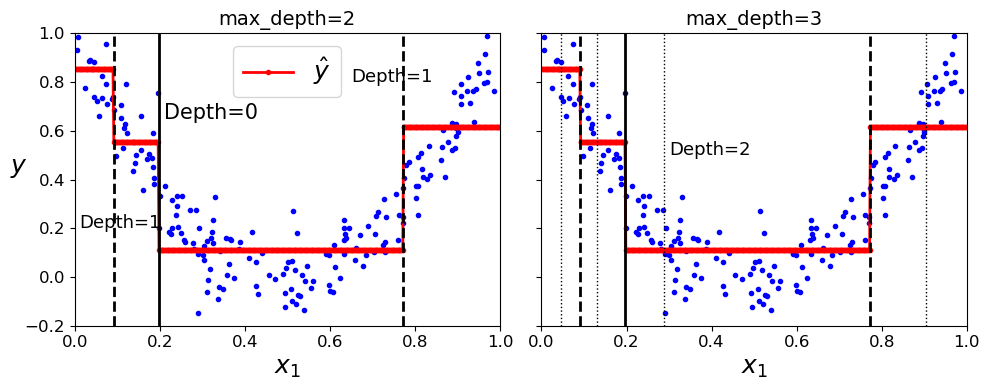

In [24]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)   #
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=2)   #
tree_reg1.fit(X,y)   # 
tree_reg2.fit(X,y)   #

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.sca(axes[1])
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

save_fig("tree_regression_plot")
plt.show()

The CART algorithm aims to minimize the MSE in the case of regression:

<img src="figures/CART_cost_function_regression.png " width ="600" />

Just like for classification tasks, Decision Trees are prone to overfitting when dealing with regression tasks too. Without any regularization, you will get the figure on the left.  With regularization, you'll get the figure on the right.

Saving figure tree_regression_regularization_plot


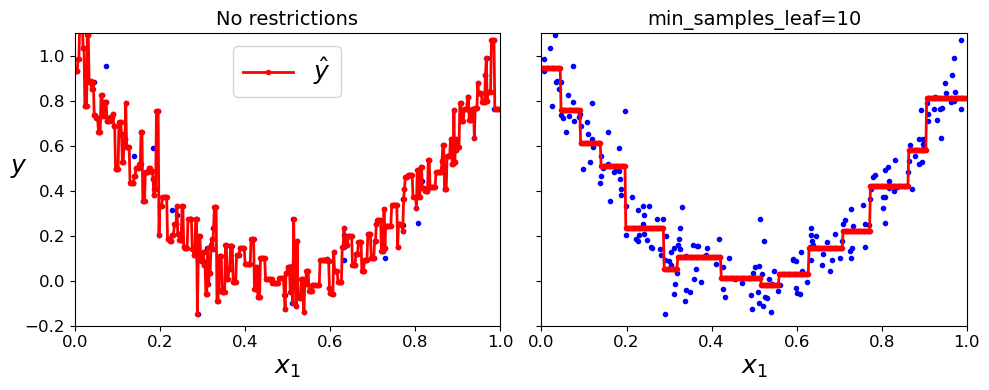

In [25]:
tree_reg1 = DecisionTreeRegressor(random_state=42) #not regularizing this sample
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10) #some regularization in this model
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)


fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.sca(axes[1])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)

save_fig("tree_regression_regularization_plot")
plt.show()

# Sensitivity to Training Set Details

One limitation of decision trees is that they only form orthogonal decision boundaries!

Saving figure sensitivity_to_rotation_plot


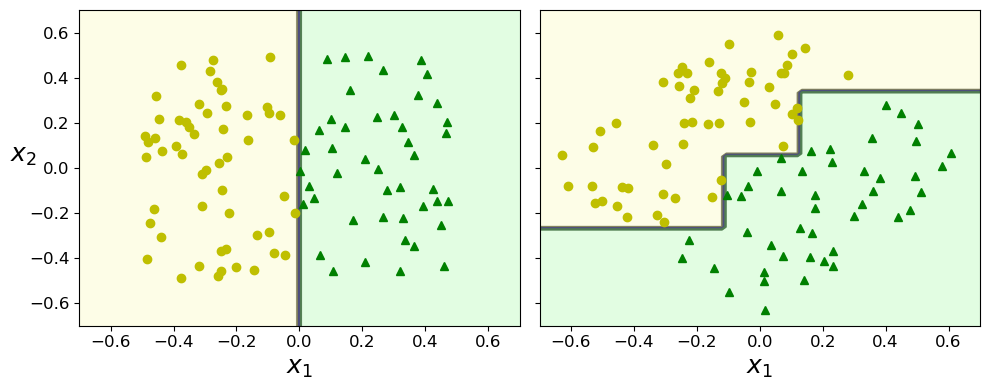

In [26]:
np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.sca(axes[1])
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.ylabel("")

save_fig("sensitivity_to_rotation_plot")
plt.show()

More generally, the main issue with Decision Trees is that they are very sensitive to small variations in the training data. For example, if you just remove the widest Iris versicolor from the iris training set, then you'll get a totally different model:

In [27]:
# Get iris data again
iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

X[(X[:, 1]==X[:, 1][y==1].max()) & (y==1)] # widest Iris versicolor flower

array([[4.8, 1.8]])

In [28]:
not_widest_versicolor = (X[:, 1]!=1.8) | (y==2) # Boolean expression
X_tweaked = X[not_widest_versicolor] # vector of boolean values
y_tweaked = y[not_widest_versicolor]

tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)    #
tree_clf_tweaked.fit(X_tweaked, y_tweaked)   #

DecisionTreeClassifier(max_depth=2, random_state=40)

Saving figure decision_tree_instability_plot


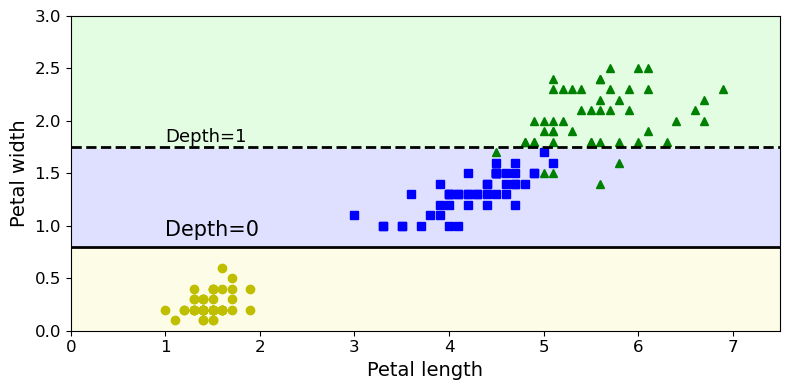

In [29]:
plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf_tweaked, X_tweaked, y_tweaked, legend=False)
plt.plot([0, 7.5], [0.8, 0.8], "k-", linewidth=2)
plt.plot([0, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.text(1.0, 0.9, "Depth=0", fontsize=15)
plt.text(1.0, 1.80, "Depth=1", fontsize=13)

save_fig("decision_tree_instability_plot")
plt.show()

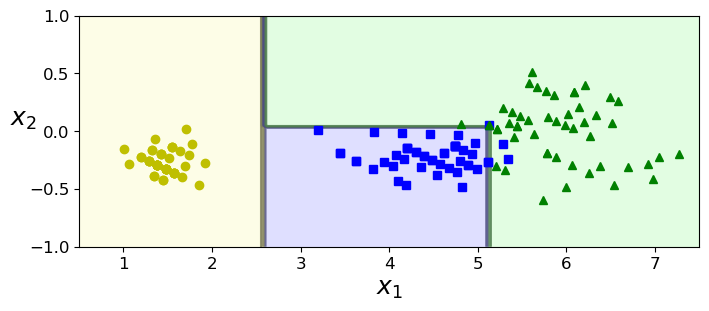

In [30]:
angle = np.pi / 180 * 20
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xr = X.dot(rotation_matrix)

tree_clf_r = DecisionTreeClassifier(random_state=42)
tree_clf_r.fit(Xr, y)

plt.figure(figsize=(8, 3))
plot_decision_boundary(tree_clf_r, Xr, y, axes=[0.5, 7.5, -1.0, 1], iris=False)

plt.show()